In [1]:
import pandas as pd 
import numpy as np

In [2]:
# Load the dataset
file_path = 'DowJones.csv'
stock_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
stock_data.head()

,Date,Value
0,1977-09-02,872.31
1,1977-09-09,857.04
2,1977-09-16,856.81
3,1977-09-23,839.14
4,1977-09-30,847.11


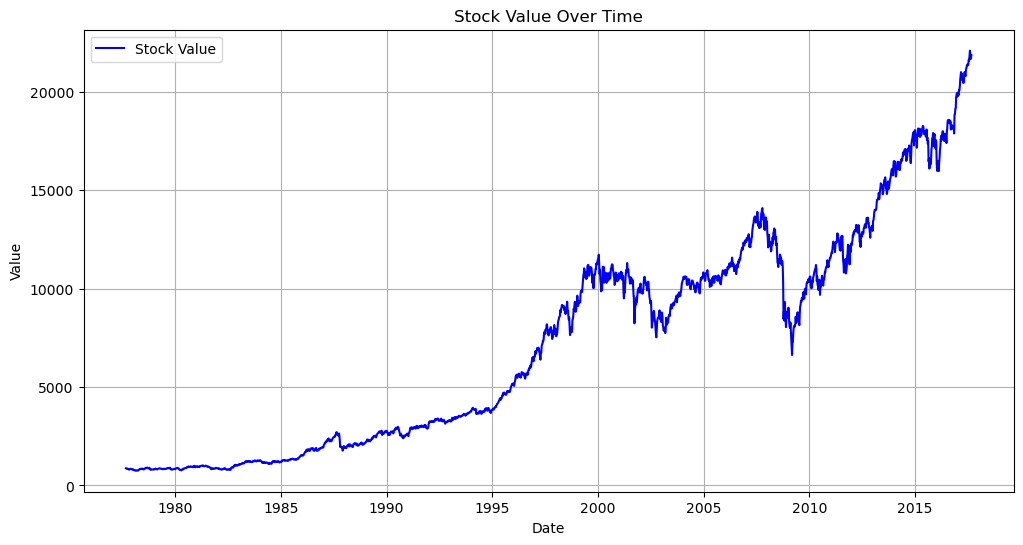

In [3]:
import matplotlib.pyplot as plt

# Convert Date column to datetime and set it as the index
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

# Plot the stock values to visualize trends
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Value'], label='Stock Value', color='blue')
plt.title('Stock Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

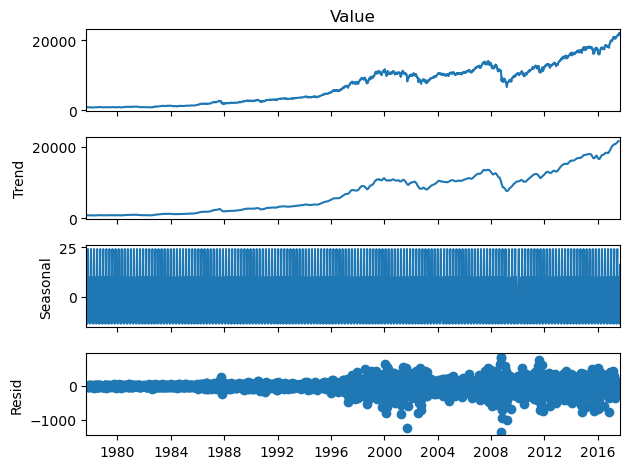

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the time series
result = seasonal_decompose(stock_data['Value'], model='additive', period=12)  # Adjust period based on your data frequency

# Plot decomposition results
result.plot()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(stock_data['Value'])

p_value= adf_test[1]

# Extract and display the results
adf_results = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations': adf_test[3],
    'Critical Values': adf_test[4],
    'Is Stationary': p_value < 0.05
}
adf_results


{'Test Statistic': 1.1566359672018125,
 'p-value': 0.9956721479952785,
 'Lags Used': 25,
 'Number of Observations': 2056,
 'Critical Values': {'1%': -3.4335345735350664,
  '5%': -2.862946794168607,
  '10%': -2.567518913543354},
 'Is Stationary': False}

In [6]:
# Apply first-order differencing to make the series stationary
stock_data['Value_diff'] = stock_data['Value'].diff()

# Drop the first NaN value resulting from differencing
differenced_data = stock_data.dropna()

# Re-check stationarity with ADF test after differencing
adf_result_diff = adfuller(differenced_data['Value_diff'])
adf_test_statistic_diff, p_value_diff, critical_values_diff = adf_result_diff[0], adf_result_diff[1], adf_result_diff[4]

# Display ADF test results for differenced data
{
    "ADF Test Statistic (Differenced)": adf_test_statistic_diff,
    "p-value (Differenced)": p_value_diff,
    "Critical Values (Differenced)": critical_values_diff,
    "Is Stationary (Differenced)": p_value_diff < 0.05
}

{'ADF Test Statistic (Differenced)': -8.09789828282761,
 'p-value (Differenced)': 1.3237926974744794e-12,
 'Critical Values (Differenced)': {'1%': -3.4335345735350664,
  '5%': -2.862946794168607,
  '10%': -2.567518913543354},
 'Is Stationary (Differenced)': True}

In [7]:
if stock_data['Value_diff'].isnull().any():
    stock_data = stock_data.dropna()

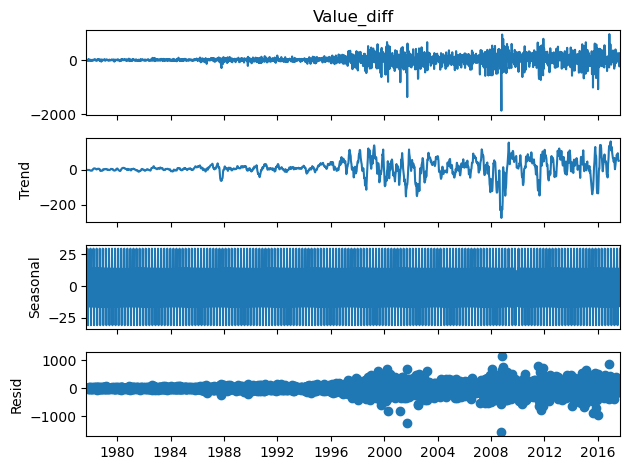

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the time series
result = seasonal_decompose(stock_data['Value_diff'], model='additive', period=12)  # Adjust period based on your data frequency

# Plot decomposition results
result.plot()
plt.show()

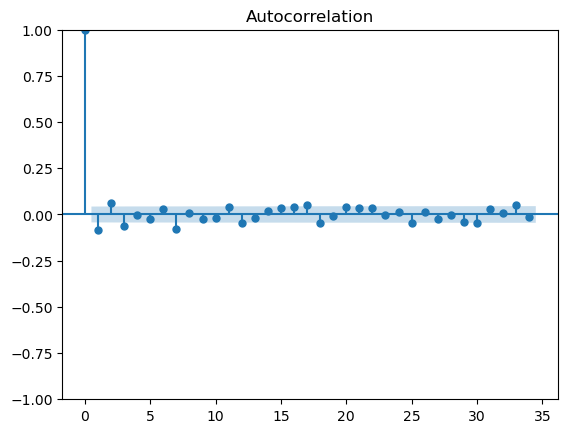

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot Autocorrelation
plot_acf(stock_data['Value_diff'])
plt.show()

In [10]:
# 1. Stabilize Variance (if needed)
stock_data['Value_diff'] = np.log1p(stock_data['Value_diff'])  # Log transformation

c:\Users\PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(differenced_data) * 0.8)
train_data, test_data = differenced_data[:train_size], differenced_data[train_size:]

# Check the sizes of train and test sets
{
    "Train Data Size": len(train_data),
    "Test Data Size": len(test_data)
}

{'Train Data Size': 1664, 'Test Data Size': 417}

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def evaluate_model(y_true, y_pred, model_name, verbose=True):
    """
    Evaluate a model's performance and return metrics.

    Parameters:
    - y_true: Array of true values
    - y_pred: Array of predicted values
    - model_name: Name of the model
    - verbose: Whether to print results

    Returns:
    - Dictionary of evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    metrics = {"Model": model_name, "RMSE": rmse, "MAE": mae, "MAPE": mape}

    if verbose:
        print(f"{model_name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4%}")
    
    return metrics

In [13]:
print(train_data['Value_diff'].isna().sum())  # Check for NaNs
print(test_data['Value_diff'].isna().sum())   # Check for NaNs
print(np.isinf(train_data['Value_diff']).sum())  # Check for Infs
print(np.isinf(test_data['Value_diff']).sum())   # Check for Infs

0
0
0
0


In [14]:
stock_data = stock_data.replace([np.inf, -np.inf], np.nan)  # Replace infinity with NaN
stock_data = stock_data.dropna()  # Remove NaN values

In [15]:
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [16]:
from skopt import BayesSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def arima_objective(order, train_data, test_data):
    try:
        model = ARIMA(train_data, order=order).fit()
        forecast = model.forecast(len(test_data))
        metrics = evaluate_model(test_data, forecast, f"ARIMA Order {order}", verbose=False)
        if np.isnan(metrics["RMSE"]) or np.isinf(metrics["RMSE"]):
            print(f"Invalid RMSE for ARIMA({order}): {metrics['RMSE']}")
            return np.inf
        return metrics["RMSE"]  # Minimizing RMSE
    except Exception as e:
        print(f"ARIMA failed for order {order} with error: {e}")
        return np.inf

# Bayesian Optimization for ARIMA
from skopt.space import Integer

search_space = [
    Integer(0, 3, name="p"),
    Integer(0, 3, name="d"),
    Integer(0, 3, name="q")
]

from skopt import gp_minimize

def arima_bayesian_optimization(train_data, test_data):
    def objective(params):
        p, d, q = params
        return arima_objective((p, d, q), train_data, test_data)
    
    result = gp_minimize(objective, search_space, n_calls=20, random_state=42)
    best_order = result.x
    print(f"Best ARIMA order: {best_order} with RMSE: {result.fun}")
    return best_order

# Example Usage
best_arima_order = arima_bayesian_optimization(train_data['Value_diff'], test_data['Value_diff'])


c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anac

Best ARIMA order: [1, 1, 0] with RMSE: 258.1312331523514


In [17]:
from skopt import gp_minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA objective
def sarima_objective(params, train_data, test_data):
    try:
        p, d, q, P, D, Q, s = params
        model = SARIMAX(train_data, 
                        order=(int(p), int(d), int(q)), 
                        seasonal_order=(int(P), int(D), int(Q), int(s)),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)
        forecast = model.forecast(steps=len(test_data))
        metrics = evaluate_model(test_data, forecast.values, f"SARIMA({params})", verbose=False)
        return metrics["RMSE"]
    except:
        return np.inf

# Bayesian Optimization for SARIMA
search_space = [
    Integer(0, 3, name="p"), Integer(0, 2, name="d"), Integer(0, 3, name="q"),
    Integer(0, 3, name="P"), Integer(0, 2, name="D"), Integer(0, 3, name="Q"),
    Integer(12, 24, name="s")  # Seasonal period
]

def sarima_bayesian_optimization(train_data, test_data):
    def objective(params):
        return sarima_objective(params, train_data, test_data)
    
    result = gp_minimize(objective, search_space, n_calls=20, random_state=42)
    best_params = result.x
    print(f"Best SARIMA parameters: {best_params} with RMSE: {result.fun}")
    return best_params

# Train and Evaluate SARIMA
best_sarima_params = sarima_bayesian_optimization(train_data['Value_diff'], test_data['Value_diff'])



c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\stat

Best SARIMA parameters: [3, 1, 1, 1, 0, 0, 17] with RMSE: 259.0269789231441


In [18]:
%pip install arch

In [19]:
from arch import arch_model

train_data['stabilized'] = np.log(train_data['Value_diff'])
test_data['stabilized'] = np.log(test_data['Value_diff'])

# Define the objective function for GARCH
def garch_objective(params, train_data, test_data):
    try:
        p, q = params
        model = arch_model(train_data, vol="Garch", p=p, q=q).fit(disp="off")
        forecast = model.forecast(horizon=len(test_data)).mean.iloc[-1]
        metrics = evaluate_model(test_data, forecast.values, f"GARCH(p={p}, q={q})", verbose=False)
        return metrics["RMSE"]
    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        return 1e6

# Bayesian Optimization for GARCH
search_space = [
    Integer(1, 5, name="p"),
    Integer(1, 5, name="q")
]

def garch_bayesian_optimization(train_data, test_data):
    def objective(params):
        return garch_objective(params, train_data, test_data)
    
    result = gp_minimize(objective, search_space, n_calls=20, random_state=42)
    best_pq = result.x
    print(f"Best GARCH(p, q): {best_pq} with RMSE: {result.fun}")
    return best_pq

# Example Usage
best_garch_params = garch_bayesian_optimization(train_data['Value_diff'], test_data['Value_diff'])


c:\Users\PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\2477198581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['stabilized'] = np.log(train_data['Value_diff'])
c:\Users\PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\2477198581.py:4: Setti

Error with parameters [4, 2]: 
Error with parameters [4, 3]: 
Error with parameters [3, 1]: 
Error with parameters [3, 2]: 
Error with parameters [2, 4]: 
Error with parameters [1, 4]: 
Error with parameters [5, 1]: 
Error with parameters [5, 3]: 
Error with parameters [3, 1]: 
Error with parameters [1, 3]: 
Error with parameters [5, 5]: 
Error with parameters [1, 5]: 


c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [1, 3]
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [4, 4]
  warnings.warn(


Error with parameters [1, 3]: 
Error with parameters [4, 4]: 


c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [2, 2]
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [2, 1]
  warnings.warn(


Error with parameters [2, 2]: 
Error with parameters [2, 1]: 


c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [3, 4]
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [2, 2]
  warnings.warn(


Error with parameters [3, 4]: 
Error with parameters [2, 2]: 


c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [4, 2]
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 5] before, using random point [3, 4]
  warnings.warn(


Error with parameters [4, 2]: 
Error with parameters [3, 4]: 
Best GARCH(p, q): [4, 2] with RMSE: 1000000.0


In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from skopt.space import Categorical, Integer

# Define ETS objective

    
def ets_objective(params, train_data, test_data):
    try:
        trend, seasonal, seasonal_periods = params
        model = ExponentialSmoothing(train_data, 
                                     trend=trend, 
                                     seasonal=seasonal, 
                                     seasonal_periods=int(seasonal_periods)).fit()
        forecast = model.forecast(steps=len(test_data))
        metrics = evaluate_model(test_data, forecast, f"ETS({params})", verbose=False)
        return metrics["RMSE"]
    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        return 1e6


# Bayesian Optimization for ETS
search_space = [
    Categorical(['add', 'mul', None], name="trend"),
    Categorical(['add', 'mul', None], name="seasonal"),
    Integer(12, 24, name="seasonal_periods")
]

def ets_bayesian_optimization(train_data, test_data):
    def objective(params):
        return ets_objective(params, train_data, test_data)
    
    result = gp_minimize(objective, search_space, n_calls=20, random_state=42)
    best_params = result.x
    print(f"Best ETS parameters: {best_params} with RMSE: {result.fun}")
    return best_params

# Train and Evaluate ETS
best_ets_params = ets_bayesian_optimization(train_data['Value_diff'], test_data['Value_diff'])


c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c

Error with parameters ['mul', 'mul', 13]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters ['mul', 'mul', 14]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters ['mul', 'add', 21]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters ['mul', 'mul', 12]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters ['add', 'mul', 17]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters ['add', 'mul', 17]: endog must be strictly positive when usingmultiplicative trend or seasonal components.
Error with parameters [None, 'mul', 22]: endog must be strictly positive when usingmultiplicative trend or seasonal components.


c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c

Error with parameters ['mul', 'mul', 16]: endog must be strictly positive when usingmultiplicative trend or seasonal components.


c:\Users\PC\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'add', 18] before, using random point ['add', 'add', 17]
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\s

Best ETS parameters: ['add', None, 15] with RMSE: 259.16931998200596


In [21]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [22]:
from prophet import Prophet

# Define the objective function for Prophet
def prophet_objective(seasonality_mode, train_data, test_data):
    try:
        model = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=True)
        model.fit(train_data.rename(columns={'Value_diff': 'y'}))
        future = model.make_future_dataframe(periods=len(test_data))
        forecast = model.predict(future).iloc[-len(test_data):]['yhat']
        metrics = evaluate_model(test_data, forecast.values, f"Prophet({seasonality_mode})", verbose=False)
        return metrics["RMSE"]
    except:
        return np.inf

# Bayesian Optimization for Prophet
search_space = ['additive', 'multiplicative']

def prophet_bayesian_optimization(train_data, test_data):
    best_rmse = float('inf')
    best_mode = None
    for mode in search_space:
        rmse = prophet_objective(mode, train_data, test_data)
        if rmse < best_rmse:
            best_rmse = rmse
            best_mode = mode
    print(f"Best Prophet Seasonality: {best_mode} with RMSE: {best_rmse}")
    return best_mode

# Example Usage
best_prophet_mode = prophet_bayesian_optimization(train_data, test_data['Value_diff'])



Best Prophet Seasonality: None with RMSE: inf


In [23]:
%pip install optuna

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from pywt import wavedec, waverec
import optuna


# Smooth the data using Exponential Moving Average (EMA)
stock_data['Smoothed'] = stock_data['Value_diff'].ewm(span=5, adjust=False).mean()

# Denoise the data using Wavelet Transform
def wavelet_denoise(series, wavelet='db1', level=1):
    coeff = wavedec(series, wavelet, level=level)
    # Set detail coefficients to zero (removes noise)
    coeff[1:] = [np.zeros_like(c) for c in coeff[1:]]
    return waverec(coeff, wavelet)

stock_data['Denoised'] = wavelet_denoise(stock_data['Value_diff'].fillna(0).values)

# Replace NaNs from wavelet reconstruction
stock_data['Denoised'] = stock_data['Denoised'].fillna(method='bfill').fillna(method='ffill')

# Split the data into train and test sets
train_size = int(len(stock_data) * 0.8)
train_data = stock_data.iloc[:train_size]
test_data = stock_data.iloc[train_size:]

# Preprocess data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data['Denoised'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['Denoised'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


from tensorflow.keras.optimizers import Adam

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Suggest hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    seq_length = trial.suggest_int('seq_length', 12, 48)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    
    # Create sequences with new sequence length
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(dropout_rate),
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean((predictions - test_data['Value_diff'][seq_length:].values)**2))
    
    return rmse

# Run Bayesian Optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best hyperparameters:", study.best_params)


C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Denoised'] = stock_data['Denoised'].fillna(method='bfill').fillna(method='ffill')
[I 2024-12-12 21:20:31,996] A new study created in memory with name: no-name-6cc1fe30-d716-409e-a7be-4f422d96364e
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model inst

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-12 21:20:42,607] Trial 0 finished with value: 1.0615705604400352 and parameters: {'lstm_units': 118, 'dropout_rate': 0.10937882509736277, 'learning_rate': 0.00027957324709015175, 'seq_length': 13, 'batch_size': 58}. Best is trial 0 with value: 1.0615705604400352.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-12 21:20:53,408] Trial 1 finished with value: 1.063610396043725 and parameters: {'lstm_units': 128, 'dropout_rate': 0.49531092073269456, 'learning_rate': 0.006990129519905658, 'seq_length': 18, 'batch_size': 89}. Best is trial 0 with value: 1.0615705604400352.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2024-12-12 21:21:03,363] Trial 2 finished with value: 1.0586957011051248 and parameters: {'lstm_units': 128, 'dropout_rate': 0.24956453351908212, 'learning_rate': 0.0029278232622636873, 'seq_length': 16, 'batch_size': 37}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


[I 2024-12-12 21:21:11,413] Trial 3 finished with value: 1.0608648548776356 and parameters: {'lstm_units': 44, 'dropout_rate': 0.30171001596808844, 'learning_rate': 0.0044305675156357605, 'seq_length': 16, 'batch_size': 118}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2024-12-12 21:21:19,920] Trial 4 finished with value: 1.0937795535050638 and parameters: {'lstm_units': 57, 'dropout_rate': 0.3941694253047424, 'learning_rate': 0.00046664770686748614, 'seq_length': 12, 'batch_size': 93}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2024-12-12 21:21:31,657] Trial 5 finished with value: 1.0735223896439505 and parameters: {'lstm_units': 115, 'dropout_rate': 0.4896496777332028, 'learning_rate': 0.0005556626945199539, 'seq_length': 32, 'batch_size': 85}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2024-12-12 21:21:43,600] Trial 6 finished with value: 1.1122553300220843 and parameters: {'lstm_units': 84, 'dropout_rate': 0.4677445965339624, 'learning_rate': 0.004029908362091604, 'seq_length': 47, 'batch_size': 127}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2024-12-12 21:21:51,494] Trial 7 finished with value: 1.1159074469210306 and parameters: {'lstm_units': 36, 'dropout_rate': 0.22456236860001125, 'learning_rate': 0.00025317340776762884, 'seq_length': 23, 'batch_size': 80}. Best is trial 2 with value: 1.0586957011051248.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-12-12 21:22:05,834] Trial 8 finished with value: 1.0493632906145054 and parameters: {'lstm_units': 127, 'dropout_rate': 0.44536224808497094, 'learning_rate': 0.002815783579186889, 'seq_length': 48, 'batch_size': 126}. Best is trial 8 with value: 1.0493632906145054.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2024-12-12 21:22:17,778] Trial 9 finished with value: 1.0606877355488027 and parameters: {'lstm_units': 50, 'dropout_rate': 0.4584189538628156, 'learning_rate': 0.0008814259147170272, 'seq_length': 29, 'batch_size': 32}. Best is trial 8 with value: 1.0493632906145054.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2024-12-12 21:22:29,803] Trial 10 finished with value: 1.0216786848805979 and parameters: {'lstm_units': 97, 'dropout_rate': 0.377157247439672, 'learning_rate': 0.0015679764700239909, 'seq_length': 48, 'batch_size': 109}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-12 21:22:42,710] Trial 11 finished with value: 1.0721219849607326 and parameters: {'lstm_units': 95, 'dropout_rate': 0.3754129318407822, 'learning_rate': 0.0020120774781809455, 'seq_length': 48, 'batch_size': 111}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


[I 2024-12-12 21:22:55,530] Trial 12 finished with value: 1.0459763944631895 and parameters: {'lstm_units': 100, 'dropout_rate': 0.37403342503360487, 'learning_rate': 0.0015524639773078317, 'seq_length': 39, 'batch_size': 101}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2024-12-12 21:23:08,339] Trial 13 finished with value: 1.0864125903680295 and parameters: {'lstm_units': 97, 'dropout_rate': 0.3423590947012993, 'learning_rate': 0.001393500306202316, 'seq_length': 40, 'batch_size': 104}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2024-12-12 21:23:19,593] Trial 14 finished with value: 1.0447512059146313 and parameters: {'lstm_units': 68, 'dropout_rate': 0.3843476415532252, 'learning_rate': 0.0008731774124223779, 'seq_length': 40, 'batch_size': 65}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-12 21:23:31,242] Trial 15 finished with value: 1.0331703026457528 and parameters: {'lstm_units': 67, 'dropout_rate': 0.2872975050082666, 'learning_rate': 0.00011248826199366717, 'seq_length': 41, 'batch_size': 64}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-12 21:23:42,863] Trial 16 finished with value: 1.0348670195630454 and parameters: {'lstm_units': 71, 'dropout_rate': 0.21317774676754678, 'learning_rate': 0.00010690467612554534, 'seq_length': 43, 'batch_size': 47}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


[I 2024-12-12 21:23:53,660] Trial 17 finished with value: 1.0546437497852246 and parameters: {'lstm_units': 80, 'dropout_rate': 0.29412149251433745, 'learning_rate': 0.00010647095556986193, 'seq_length': 33, 'batch_size': 73}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2024-12-12 21:24:07,292] Trial 18 finished with value: 1.0415105670325937 and parameters: {'lstm_units': 66, 'dropout_rate': 0.1564344755643105, 'learning_rate': 0.00020292481255586206, 'seq_length': 36, 'batch_size': 20}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-12 21:24:18,844] Trial 19 finished with value: 1.0500402897378793 and parameters: {'lstm_units': 91, 'dropout_rate': 0.300631815761727, 'learning_rate': 0.0005134369554962672, 'seq_length': 43, 'batch_size': 58}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2024-12-12 21:24:28,395] Trial 20 finished with value: 1.1250726745359263 and parameters: {'lstm_units': 110, 'dropout_rate': 0.4144331458743835, 'learning_rate': 0.008089011069171523, 'seq_length': 26, 'batch_size': 75}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[I 2024-12-12 21:24:40,191] Trial 21 finished with value: 1.0380189613726292 and parameters: {'lstm_units': 74, 'dropout_rate': 0.21785304394588662, 'learning_rate': 0.00010929843700043517, 'seq_length': 44, 'batch_size': 47}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2024-12-12 21:24:54,762] Trial 22 finished with value: 1.0431830843540857 and parameters: {'lstm_units': 58, 'dropout_rate': 0.16979527959247445, 'learning_rate': 0.00016310329613719495, 'seq_length': 44, 'batch_size': 47}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2024-12-12 21:25:08,377] Trial 23 finished with value: 1.0442148310737964 and parameters: {'lstm_units': 87, 'dropout_rate': 0.2665871971561999, 'learning_rate': 0.00012990352160720814, 'seq_length': 36, 'batch_size': 46}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2024-12-12 21:25:23,220] Trial 24 finished with value: 1.037277658154743 and parameters: {'lstm_units': 74, 'dropout_rate': 0.34792416810663884, 'learning_rate': 0.0002756089256991245, 'seq_length': 43, 'batch_size': 63}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


[I 2024-12-12 21:25:39,488] Trial 25 finished with value: 1.0469242374783252 and parameters: {'lstm_units': 105, 'dropout_rate': 0.19109003867115543, 'learning_rate': 0.00037898500068328766, 'seq_length': 36, 'batch_size': 27}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


[I 2024-12-12 21:25:53,160] Trial 26 finished with value: 1.034095079500983 and parameters: {'lstm_units': 63, 'dropout_rate': 0.3241651224393347, 'learning_rate': 0.00016698654326035973, 'seq_length': 45, 'batch_size': 55}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


[I 2024-12-12 21:26:07,979] Trial 27 finished with value: 1.0474474527026663 and parameters: {'lstm_units': 61, 'dropout_rate': 0.3320714024249775, 'learning_rate': 0.0001799610893515444, 'seq_length': 45, 'batch_size': 68}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2024-12-12 21:26:21,162] Trial 28 finished with value: 1.0319075562723201 and parameters: {'lstm_units': 79, 'dropout_rate': 0.42538239075238693, 'learning_rate': 0.0006758142514133739, 'seq_length': 39, 'batch_size': 54}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


[I 2024-12-12 21:26:33,818] Trial 29 finished with value: 1.0645372465175862 and parameters: {'lstm_units': 80, 'dropout_rate': 0.4242009902359779, 'learning_rate': 0.0007508542070407971, 'seq_length': 39, 'batch_size': 99}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2024-12-12 21:26:47,294] Trial 30 finished with value: 1.0549904976535665 and parameters: {'lstm_units': 51, 'dropout_rate': 0.11933715918533222, 'learning_rate': 0.0014831647885919464, 'seq_length': 38, 'batch_size': 56}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2024-12-12 21:27:00,037] Trial 31 finished with value: 1.0516902219609616 and parameters: {'lstm_units': 62, 'dropout_rate': 0.3230197928463464, 'learning_rate': 0.00037199703620096236, 'seq_length': 41, 'batch_size': 54}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[I 2024-12-12 21:27:14,460] Trial 32 finished with value: 1.0582784233532065 and parameters: {'lstm_units': 78, 'dropout_rate': 0.3581352366193914, 'learning_rate': 0.0011936661475920767, 'seq_length': 46, 'batch_size': 39}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


[I 2024-12-12 21:27:28,142] Trial 33 finished with value: 1.0378773133167254 and parameters: {'lstm_units': 89, 'dropout_rate': 0.2632170601932951, 'learning_rate': 0.0001457798932945084, 'seq_length': 42, 'batch_size': 63}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


[I 2024-12-12 21:27:42,647] Trial 34 finished with value: 1.091189672697143 and parameters: {'lstm_units': 48, 'dropout_rate': 0.424926311198102, 'learning_rate': 0.0021542328688017543, 'seq_length': 46, 'batch_size': 81}. Best is trial 10 with value: 1.0216786848805979.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2024-12-12 21:27:55,742] Trial 35 finished with value: 1.0210348268079932 and parameters: {'lstm_units': 66, 'dropout_rate': 0.4015403105589424, 'learning_rate': 0.00021974580103524237, 'seq_length': 48, 'batch_size': 39}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-12 21:28:06,938] Trial 36 finished with value: 1.0512189303875132 and parameters: {'lstm_units': 83, 'dropout_rate': 0.4999260114589646, 'learning_rate': 0.00023390072352365136, 'seq_length': 33, 'batch_size': 40}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2024-12-12 21:28:27,374] Trial 37 finished with value: 1.1908724593972504 and parameters: {'lstm_units': 105, 'dropout_rate': 0.3909988549018095, 'learning_rate': 0.00038411747147857836, 'seq_length': 48, 'batch_size': 20}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


[I 2024-12-12 21:28:36,968] Trial 38 finished with value: 1.1029883088038626 and parameters: {'lstm_units': 55, 'dropout_rate': 0.40784732375098687, 'learning_rate': 0.005582723048222877, 'seq_length': 29, 'batch_size': 90}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


[I 2024-12-12 21:28:50,194] Trial 39 finished with value: 1.1241211115406289 and parameters: {'lstm_units': 75, 'dropout_rate': 0.44337549862076847, 'learning_rate': 0.0006891276526312989, 'seq_length': 37, 'batch_size': 30}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2024-12-12 21:28:58,370] Trial 40 finished with value: 1.0657874568900196 and parameters: {'lstm_units': 39, 'dropout_rate': 0.2751017913385935, 'learning_rate': 0.0029120340050731606, 'seq_length': 20, 'batch_size': 117}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2024-12-12 21:29:12,273] Trial 41 finished with value: 1.028122042763644 and parameters: {'lstm_units': 67, 'dropout_rate': 0.31883667301173974, 'learning_rate': 0.0002894435579777082, 'seq_length': 46, 'batch_size': 52}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2024-12-12 21:29:22,754] Trial 42 finished with value: 1.0563481045829068 and parameters: {'lstm_units': 68, 'dropout_rate': 0.36102974985490577, 'learning_rate': 0.00031801109510215433, 'seq_length': 46, 'batch_size': 51}. Best is trial 35 with value: 1.0210348268079932.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2024-12-12 21:29:35,549] Trial 43 finished with value: 1.002343227760601 and parameters: {'lstm_units': 70, 'dropout_rate': 0.4725030557846942, 'learning_rate': 0.00022170890150768796, 'seq_length': 48, 'batch_size': 35}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-12 21:29:51,413] Trial 44 finished with value: 1.0362594429618994 and parameters: {'lstm_units': 120, 'dropout_rate': 0.4743264392361268, 'learning_rate': 0.00023255619419320443, 'seq_length': 48, 'batch_size': 36}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2024-12-12 21:30:05,787] Trial 45 finished with value: 1.0729452563920685 and parameters: {'lstm_units': 85, 'dropout_rate': 0.44989959755879433, 'learning_rate': 0.0005918913020697122, 'seq_length': 46, 'batch_size': 42}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2024-12-12 21:30:27,463] Trial 46 finished with value: 1.0428131724093872 and parameters: {'lstm_units': 92, 'dropout_rate': 0.4739322981871143, 'learning_rate': 0.001139387449383065, 'seq_length': 48, 'batch_size': 26}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2024-12-12 21:30:41,547] Trial 47 finished with value: 1.0404606859045413 and parameters: {'lstm_units': 71, 'dropout_rate': 0.4350762733531426, 'learning_rate': 0.0003273183642994851, 'seq_length': 45, 'batch_size': 34}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2024-12-12 21:30:54,565] Trial 48 finished with value: 1.055247040859484 and parameters: {'lstm_units': 78, 'dropout_rate': 0.4022244609294019, 'learning_rate': 0.0019939277594907914, 'seq_length': 47, 'batch_size': 42}. Best is trial 43 with value: 1.002343227760601.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\873535974.py:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2024-12-12 21:31:09,233] Trial 49 finished with value: 1.043584820307323 and parameters: {'lstm_units': 58, 'dropout_rate': 0.3706742018919459, 'learning_rate': 0.0004577535695953869, 'seq_length': 42, 'batch_size': 24}. Best is trial 43 with value: 1.002343227760601.


Best hyperparameters: {'lstm_units': 70, 'dropout_rate': 0.4725030557846942, 'learning_rate': 0.00022170890150768796, 'seq_length': 48, 'batch_size': 35}


In [25]:
# Extract best parameters from the Bayesian optimization study
best_params = study.best_params
print("Best Parameters:", best_params)

# Create sequences using the optimized sequence length
seq_length = best_params['seq_length']
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the final LSTM model with optimized parameters
model = Sequential([
    LSTM(best_params['lstm_units'], return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units']),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mse')

# Train the final model
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], validation_split=0.2, verbose=1)

# Predict on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate performance metrics
actual_values = test_data['Value_diff'][seq_length:].values
lstm_result = evaluate_model(actual_values, predictions, "Optimized LSTM")



Best Parameters: {'lstm_units': 70, 'dropout_rate': 0.4725030557846942, 'learning_rate': 0.00022170890150768796, 'seq_length': 48, 'batch_size': 35}


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 587ms/step - loss: 0.1675 - val_loss: 0.0179
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0325 - val_loss: 0.0233
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0232 - val_loss: 0.0146
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0219 - val_loss: 0.0157
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0208 - val_loss: 0.0164
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0255 - val_loss: 0.0143
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0228 - val_loss: 0.0156
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0228 - val_loss: 0.0148
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0224 - val_loss: 0.0153
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0206 - val_loss: 0.0159
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0184 - val_loss: 0.0170
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0

In [26]:
from tensorflow.keras.layers import Bidirectional

# Build Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train and Evaluate
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
predictions_bilstm = model.predict(X_test)
predictions_bilstm = scaler.inverse_transform(predictions_bilstm)
evaluate_model(test_data['Value_diff'][seq_length:].values, predictions_bilstm, "Bidirectional LSTM")


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - loss: 0.0793 - val_loss: 0.0147
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0190 - val_loss: 0.0143
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0179 - val_loss: 0.0142
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0168 - val_loss: 0.0205
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0170 - val_loss: 0.0139
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0163 - val_loss: 0.0139
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0179 - val_loss: 0.0138
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0174 - val_loss: 0.0138
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.

{'Model': 'Bidirectional LSTM',
 'RMSE': 0.9946132646017177,
 'MAE': 0.7522855221545385,
 'MAPE': 0.18969389442075393}

In [27]:
import optuna
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def objective(trial):
    # Define the hyperparameters to optimize
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 10, 50)
    seq_length = trial.suggest_int('seq_length', 12, 48)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Build Bidirectional LSTM model
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=(seq_length, 1)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Predict on the test set
    predictions_bilstm = model.predict(X_test)
    predictions_bilstm = scaler.inverse_transform(predictions_bilstm)
    
    rmse = np.sqrt(np.mean((predictions_bilstm - test_data['Value_diff'][seq_length:].values)**2))
    
    return rmse
    

# Create the study and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for optimization
    

# Best parameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-12 21:32:18,000] A new study created in memory with name: no-name-d61a50fe-9ef4-41cf-96d8-c8497b18e7e0
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


[I 2024-12-12 21:33:03,418] Trial 0 finished with value: 1.0517403359508035 and parameters: {'lstm_units': 36, 'dropout_rate': 0.3485680204898107, 'batch_size': 44, 'epochs': 49, 'seq_length': 26, 'learning_rate': 0.0009989486313994628}. Best is trial 0 with value: 1.0517403359508035.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


[I 2024-12-12 21:34:06,441] Trial 1 finished with value: 1.0832689056448375 and parameters: {'lstm_units': 78, 'dropout_rate': 0.3397427413345263, 'batch_size': 36, 'epochs': 37, 'seq_length': 35, 'learning_rate': 0.0024713490455381495}. Best is trial 0 with value: 1.0517403359508035.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


[I 2024-12-12 21:35:19,270] Trial 2 finished with value: 1.038275142547671 and parameters: {'lstm_units': 55, 'dropout_rate': 0.15447228785675096, 'batch_size': 16, 'epochs': 42, 'seq_length': 16, 'learning_rate': 0.00015063445440227226}. Best is trial 2 with value: 1.038275142547671.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


[I 2024-12-12 21:35:40,089] Trial 3 finished with value: 1.0372564730623604 and parameters: {'lstm_units': 51, 'dropout_rate': 0.13730760327496738, 'batch_size': 40, 'epochs': 11, 'seq_length': 19, 'learning_rate': 0.0002933676047049663}. Best is trial 3 with value: 1.0372564730623604.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


[I 2024-12-12 21:36:46,957] Trial 4 finished with value: 1.055766294060013 and parameters: {'lstm_units': 68, 'dropout_rate': 0.1636957709565241, 'batch_size': 25, 'epochs': 36, 'seq_length': 28, 'learning_rate': 0.000150378901450185}. Best is trial 3 with value: 1.0372564730623604.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-12-12 21:37:36,423] Trial 5 finished with value: 1.0380677384974144 and parameters: {'lstm_units': 84, 'dropout_rate': 0.38385363427295793, 'batch_size': 41, 'epochs': 33, 'seq_length': 16, 'learning_rate': 0.0003858348511319467}. Best is trial 3 with value: 1.0372564730623604.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


[I 2024-12-12 21:38:19,911] Trial 6 finished with value: 1.0448568882482236 and parameters: {'lstm_units': 119, 'dropout_rate': 0.4475039876730924, 'batch_size': 57, 'epochs': 23, 'seq_length': 17, 'learning_rate': 0.0005604160881572597}. Best is trial 3 with value: 1.0372564730623604.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-12 21:38:59,183] Trial 7 finished with value: 1.0393689739285001 and parameters: {'lstm_units': 64, 'dropout_rate': 0.415139601772326, 'batch_size': 25, 'epochs': 23, 'seq_length': 34, 'learning_rate': 0.00023792975785834485}. Best is trial 3 with value: 1.0372564730623604.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-12 21:40:20,888] Trial 8 finished with value: 1.0222787434955423 and parameters: {'lstm_units': 108, 'dropout_rate': 0.42955416422403436, 'batch_size': 49, 'epochs': 46, 'seq_length': 44, 'learning_rate': 6.684860282659675e-05}. Best is trial 8 with value: 1.0222787434955423.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[I 2024-12-12 21:40:57,490] Trial 9 finished with value: 1.07842687846835 and parameters: {'lstm_units': 124, 'dropout_rate': 0.37778613840351316, 'batch_size': 21, 'epochs': 10, 'seq_length': 16, 'learning_rate': 0.0002952378806127746}. Best is trial 8 with value: 1.0222787434955423.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:42:02,304] Trial 10 finished with value: 1.0139028314095624 and parameters: {'lstm_units': 102, 'dropout_rate': 0.4939779869301941, 'batch_size': 61, 'epochs': 49, 'seq_length': 46, 'learning_rate': 1.5087691912705585e-05}. Best is trial 10 with value: 1.0139028314095624.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-12 21:43:25,572] Trial 11 finished with value: 0.9892845853089985 and parameters: {'lstm_units': 104, 'dropout_rate': 0.49000524112440874, 'batch_size': 63, 'epochs': 50, 'seq_length': 48, 'learning_rate': 1.682654391901315e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[I 2024-12-12 21:44:38,521] Trial 12 finished with value: 1.0148474111203545 and parameters: {'lstm_units': 97, 'dropout_rate': 0.47967641099052566, 'batch_size': 64, 'epochs': 50, 'seq_length': 46, 'learning_rate': 1.20121757313604e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:45:34,234] Trial 13 finished with value: 1.0116973521422172 and parameters: {'lstm_units': 98, 'dropout_rate': 0.25956787773249546, 'batch_size': 62, 'epochs': 41, 'seq_length': 42, 'learning_rate': 1.0404473661586018e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:46:27,123] Trial 14 finished with value: 1.0075700828077179 and parameters: {'lstm_units': 91, 'dropout_rate': 0.23598262792448166, 'batch_size': 54, 'epochs': 41, 'seq_length': 40, 'learning_rate': 3.36399407017825e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-12-12 21:47:30,940] Trial 15 finished with value: 1.006157339922725 and parameters: {'lstm_units': 87, 'dropout_rate': 0.24458735203499446, 'batch_size': 53, 'epochs': 27, 'seq_length': 40, 'learning_rate': 4.1995921094828747e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


[I 2024-12-12 21:48:20,591] Trial 16 finished with value: 1.0302553852830034 and parameters: {'lstm_units': 113, 'dropout_rate': 0.22344434079668346, 'batch_size': 51, 'epochs': 27, 'seq_length': 37, 'learning_rate': 4.159025159854441e-05}. Best is trial 11 with value: 0.9892845853089985.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


[I 2024-12-12 21:48:50,337] Trial 17 finished with value: 0.9875876221103882 and parameters: {'lstm_units': 82, 'dropout_rate': 0.2812312387828855, 'batch_size': 57, 'epochs': 17, 'seq_length': 48, 'learning_rate': 2.7068861323038272e-05}. Best is trial 17 with value: 0.9875876221103882.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:49:15,248] Trial 18 finished with value: 0.9875325530465093 and parameters: {'lstm_units': 76, 'dropout_rate': 0.29904495454736646, 'batch_size': 58, 'epochs': 16, 'seq_length': 48, 'learning_rate': 2.3070014156420432e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-12 21:49:43,037] Trial 19 finished with value: 1.0898454583814268 and parameters: {'lstm_units': 70, 'dropout_rate': 0.29656760231738793, 'batch_size': 34, 'epochs': 16, 'seq_length': 24, 'learning_rate': 0.008683390182156806}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


[I 2024-12-12 21:50:23,410] Trial 20 finished with value: 1.0409125021130519 and parameters: {'lstm_units': 75, 'dropout_rate': 0.29898231600674474, 'batch_size': 48, 'epochs': 17, 'seq_length': 32, 'learning_rate': 6.790823407469158e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


[I 2024-12-12 21:50:48,307] Trial 21 finished with value: 0.9896596027181931 and parameters: {'lstm_units': 55, 'dropout_rate': 0.18820097707054706, 'batch_size': 57, 'epochs': 16, 'seq_length': 48, 'learning_rate': 2.6664689178497664e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[I 2024-12-12 21:51:22,230] Trial 22 finished with value: 0.9898773839410075 and parameters: {'lstm_units': 90, 'dropout_rate': 0.32399286140491235, 'batch_size': 58, 'epochs': 20, 'seq_length': 48, 'learning_rate': 2.080987309304402e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


[I 2024-12-12 21:51:50,312] Trial 23 finished with value: 1.0181673621451799 and parameters: {'lstm_units': 106, 'dropout_rate': 0.1000675177089399, 'batch_size': 64, 'epochs': 12, 'seq_length': 44, 'learning_rate': 7.959221580549722e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-12 21:52:46,692] Trial 24 finished with value: 1.0027121383448263 and parameters: {'lstm_units': 80, 'dropout_rate': 0.2758208724199698, 'batch_size': 59, 'epochs': 29, 'seq_length': 39, 'learning_rate': 2.0120722927295376e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


[I 2024-12-12 21:53:22,339] Trial 25 finished with value: 1.01472071075401 and parameters: {'lstm_units': 62, 'dropout_rate': 0.20194351318164566, 'batch_size': 46, 'epochs': 23, 'seq_length': 43, 'learning_rate': 0.00011063027901277156}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 


[I 2024-12-12 21:53:49,642] Trial 26 finished with value: 1.0006293358507001 and parameters: {'lstm_units': 45, 'dropout_rate': 0.37395964380461066, 'batch_size': 54, 'epochs': 19, 'seq_length': 48, 'learning_rate': 4.359792897166364e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


[I 2024-12-12 21:54:17,660] Trial 27 finished with value: 1.0137966892195982 and parameters: {'lstm_units': 95, 'dropout_rate': 0.31915136262786287, 'batch_size': 55, 'epochs': 14, 'seq_length': 45, 'learning_rate': 1.95544336167414e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[I 2024-12-12 21:54:58,478] Trial 28 finished with value: 1.0089508902047963 and parameters: {'lstm_units': 71, 'dropout_rate': 0.2743374793796757, 'batch_size': 60, 'epochs': 33, 'seq_length': 41, 'learning_rate': 1.1851933221022542e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-12 21:55:47,280] Trial 29 finished with value: 1.0454448540265995 and parameters: {'lstm_units': 34, 'dropout_rate': 0.34501104509210456, 'batch_size': 44, 'epochs': 20, 'seq_length': 12, 'learning_rate': 0.0013387814752194647}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


[I 2024-12-12 21:56:19,564] Trial 30 finished with value: 1.0317209831189087 and parameters: {'lstm_units': 112, 'dropout_rate': 0.40288459309900004, 'batch_size': 50, 'epochs': 13, 'seq_length': 23, 'learning_rate': 3.0469627374292693e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:56:44,713] Trial 31 finished with value: 1.174771765649503 and parameters: {'lstm_units': 42, 'dropout_rate': 0.20708252656948595, 'batch_size': 57, 'epochs': 15, 'seq_length': 48, 'learning_rate': 2.5341653449200837e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-12-12 21:57:13,323] Trial 32 finished with value: 0.9899571629581734 and parameters: {'lstm_units': 57, 'dropout_rate': 0.21231455782049252, 'batch_size': 64, 'epochs': 18, 'seq_length': 48, 'learning_rate': 5.9888075560206814e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-12-12 21:57:54,872] Trial 33 finished with value: 1.0273092818559408 and parameters: {'lstm_units': 77, 'dropout_rate': 0.19530340990980893, 'batch_size': 35, 'epochs': 25, 'seq_length': 37, 'learning_rate': 1.5454055849014945e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-12 21:58:22,963] Trial 34 finished with value: 1.0141619283560421 and parameters: {'lstm_units': 50, 'dropout_rate': 0.15914608548202575, 'batch_size': 56, 'epochs': 21, 'seq_length': 46, 'learning_rate': 0.00010015449034618442}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


[I 2024-12-12 21:59:47,221] Trial 35 finished with value: 1.0115558675423164 and parameters: {'lstm_units': 58, 'dropout_rate': 0.12452387192428163, 'batch_size': 60, 'epochs': 45, 'seq_length': 43, 'learning_rate': 2.7163681441135413e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


[I 2024-12-12 22:00:51,700] Trial 36 finished with value: 1.0218245572531282 and parameters: {'lstm_units': 82, 'dropout_rate': 0.32447459228367576, 'batch_size': 52, 'epochs': 36, 'seq_length': 46, 'learning_rate': 4.8136939851290775e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


[I 2024-12-12 22:01:43,265] Trial 37 finished with value: 1.039671488171714 and parameters: {'lstm_units': 43, 'dropout_rate': 0.46254694164826055, 'batch_size': 31, 'epochs': 32, 'seq_length': 29, 'learning_rate': 0.00016672284930753208}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[I 2024-12-12 22:02:56,184] Trial 38 finished with value: 1.0629519826795835 and parameters: {'lstm_units': 63, 'dropout_rate': 0.3527169154997861, 'batch_size': 44, 'epochs': 38, 'seq_length': 38, 'learning_rate': 0.002412450567485012}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[I 2024-12-12 22:03:25,365] Trial 39 finished with value: 1.0782640177064744 and parameters: {'lstm_units': 50, 'dropout_rate': 0.18100887606448823, 'batch_size': 41, 'epochs': 16, 'seq_length': 34, 'learning_rate': 1.670450721856009e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-12 22:03:56,477] Trial 40 finished with value: 1.011463708988373 and parameters: {'lstm_units': 126, 'dropout_rate': 0.2757045407672686, 'batch_size': 62, 'epochs': 10, 'seq_length': 42, 'learning_rate': 2.947458579610198e-05}. Best is trial 18 with value: 0.9875325530465093.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2024-12-12 22:05:15,754] Trial 41 finished with value: 0.9857094391281777 and parameters: {'lstm_units': 90, 'dropout_rate': 0.315795149687101, 'batch_size': 58, 'epochs': 20, 'seq_length': 48, 'learning_rate': 2.1645028471729305e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


[I 2024-12-12 22:05:44,938] Trial 42 finished with value: 1.0142455985032952 and parameters: {'lstm_units': 86, 'dropout_rate': 0.24377143719458014, 'batch_size': 56, 'epochs': 13, 'seq_length': 45, 'learning_rate': 2.4124554313631134e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


[I 2024-12-12 22:06:25,796] Trial 43 finished with value: 0.9893432702488327 and parameters: {'lstm_units': 104, 'dropout_rate': 0.4343272842921991, 'batch_size': 58, 'epochs': 22, 'seq_length': 48, 'learning_rate': 1.082445992418325e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[I 2024-12-12 22:07:07,292] Trial 44 finished with value: 1.0134444998003802 and parameters: {'lstm_units': 101, 'dropout_rate': 0.4434005418191733, 'batch_size': 62, 'epochs': 23, 'seq_length': 46, 'learning_rate': 1.458443884642872e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-12 22:07:47,272] Trial 45 finished with value: 1.0137198487510333 and parameters: {'lstm_units': 92, 'dropout_rate': 0.48559666041598487, 'batch_size': 59, 'epochs': 22, 'seq_length': 44, 'learning_rate': 1.1633970625561611e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-12 22:08:27,959] Trial 46 finished with value: 1.015856733486372 and parameters: {'lstm_units': 120, 'dropout_rate': 0.40545970776811735, 'batch_size': 47, 'epochs': 18, 'seq_length': 47, 'learning_rate': 1.566263002336427e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


[I 2024-12-12 22:10:04,789] Trial 47 finished with value: 1.0299445105101415 and parameters: {'lstm_units': 105, 'dropout_rate': 0.36203601171518085, 'batch_size': 52, 'epochs': 25, 'seq_length': 42, 'learning_rate': 0.0006520977417959952}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


[I 2024-12-12 22:11:00,277] Trial 48 finished with value: 1.0148767592706975 and parameters: {'lstm_units': 110, 'dropout_rate': 0.4751610049044635, 'batch_size': 62, 'epochs': 26, 'seq_length': 45, 'learning_rate': 1.0209627273356914e-05}. Best is trial 41 with value: 0.9857094391281777.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\4008214467.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


[I 2024-12-12 22:12:17,002] Trial 49 finished with value: 1.0178691185909687 and parameters: {'lstm_units': 101, 'dropout_rate': 0.44345957293957794, 'batch_size': 54, 'epochs': 47, 'seq_length': 44, 'learning_rate': 3.760719036504193e-05}. Best is trial 41 with value: 0.9857094391281777.


Best hyperparameters: {'lstm_units': 90, 'dropout_rate': 0.315795149687101, 'batch_size': 58, 'epochs': 20, 'seq_length': 48, 'learning_rate': 2.1645028471729305e-05}


In [28]:
# Extract the best parameters from the optimization study
best_params = study.best_params
print("Best Parameters:", best_params)

# Create sequences using the optimized sequence length
seq_length = best_params['seq_length']
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the final Bidirectional LSTM model with optimized parameters
model = Sequential([
    Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(best_params['dropout_rate']),
    Bidirectional(LSTM(best_params['lstm_units'])),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mse')

# Train the final model with optimized parameters
model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2, verbose=1)

# Predict on the test set
predictions_bilstm = model.predict(X_test)
predictions_bilstm = scaler.inverse_transform(predictions_bilstm)

# Evaluate performance metrics
bilstm_result = evaluate_model(test_data['Value_diff'][seq_length:].values, predictions_bilstm, "Optimized Bidirectional LSTM")

Best Parameters: {'lstm_units': 90, 'dropout_rate': 0.315795149687101, 'batch_size': 58, 'epochs': 20, 'seq_length': 48, 'learning_rate': 2.1645028471729305e-05}


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - loss: 0.2474 - val_loss: 0.3757
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.1998 - val_loss: 0.2869
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1514 - val_loss: 0.2103
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.1065 - val_loss: 0.1457
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0788 - val_loss: 0.0925
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0526 - val_loss: 0.0536
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0352 - val_loss: 0.0296
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0232 - val_loss: 0.0184
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0186 - val_loss: 0.0152
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0180 - val_loss: 0.0147
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0196 - val_loss: 0.0147
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
from tensorflow.keras.layers import Attention


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs  # Using self-attention
        # Compute attention scores
        score = tf.matmul(query, tf.transpose(value, perm=[0, 2, 1]))  # (batch_size, seq_len, seq_len)
        score = tf.nn.softmax(score, axis=-1)  # Normalize scores
        # Apply attention scores to the values
        attention = tf.matmul(score, value)  # (batch_size, seq_len, features)
        return attention

    def compute_output_shape(self, input_shape):
        # Maintain the shape after attention
        return input_shape


# Define input shape
seq_length = X_train.shape[1]  # Assuming X_train has the shape (batch_size, seq_length, features)

# Build the model
inputs = tf.keras.Input(shape=(seq_length, 1))  # Input shape
lstm_out = LSTM(50, return_sequences=True)(inputs)  # LSTM with return_sequences=True
attention_out = AttentionLayer()(lstm_out)  # Single input to the custom AttentionLayer
lstm_out2 = LSTM(50)(attention_out)  # Second LSTM processes attention output
output = Dense(1)(lstm_out2)  # Dense layer for final output
model = tf.keras.Model(inputs=inputs, outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions and evaluate
predictions_attention = model.predict(X_test)
predictions_attention = scaler.inverse_transform(predictions_attention)
evaluate_model(test_data['Value_diff'][seq_length:].values, predictions_attention, "Attention-LSTM")


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0930 - val_loss: 0.0195
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0166 - val_loss: 0.0174
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0170 - val_loss: 0.0162
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0144 - val_loss: 0.0168
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0

{'Model': 'Attention-LSTM',
 'RMSE': 1.0155718071657105,
 'MAE': 0.7650269914922309,
 'MAPE': 0.19270418675431186}

In [30]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def objective(trial):
    # Define the hyperparameter search space
    lstm_units1 = trial.suggest_int("lstm_units1", 32, 128)
    lstm_units2 = trial.suggest_int("lstm_units2", 32, 128)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    
    # Define the model
    inputs = tf.keras.Input(shape=(seq_length, 1))
    lstm_out = LSTM(lstm_units1, return_sequences=True)(inputs)
    attention_out = AttentionLayer()(lstm_out)
    lstm_out2 = LSTM(lstm_units2)(attention_out)
    output = Dense(1)(lstm_out2)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    
    # Fit the model
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Predict and calculate validation loss
    predictions = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions)
    val_loss = mean_squared_error(test_data['Value_diff'][seq_length:].values, predictions)
    
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Display the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-12 22:13:25,211] A new study created in memory with name: no-name-3b5407f0-e454-4f2e-a073-e5a37a45eae6
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\3048501396.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2024-12-12 22:14:00,986] Trial 0 finished with value: 0.9885582951052282 and parameters: {'lstm_units1': 85, 'lstm_units2': 78, 'learning_rate': 0.005063502038319384, 'batch_size': 16}. Best is trial 0 with value: 0.9885582951052282.
C:\Users\PC\AppData\Local\Temp\ipykernel_14152\3048501396.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_logunif

Best hyperparameters: {'lstm_units1': 36, 'lstm_units2': 44, 'learning_rate': 0.0011072413450287696, 'batch_size': 128}


In [31]:
best_params = study.best_params

# Build the final model
inputs = tf.keras.Input(shape=(seq_length, 1))
lstm_out = LSTM(best_params["lstm_units1"], return_sequences=True)(inputs)
attention_out = AttentionLayer()(lstm_out)
lstm_out2 = LSTM(best_params["lstm_units2"])(attention_out)
output = Dense(1)(lstm_out2)
final_model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]), loss='mse')

# Train the model
final_model.fit(X_train, y_train, epochs=50, batch_size=best_params["batch_size"], validation_split=0.2, verbose=1)

# Evaluate the model
predictions_attention = final_model.predict(X_test)
predictions_attention = scaler.inverse_transform(predictions_attention)
evaluate_model(test_data['Value_diff'][seq_length:].values, predictions_attention, "Optimized Attention-LSTM")

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.1865 - val_loss: 0.0264
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0276 - val_loss: 0.0188
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0212 - val_loss: 0.0389
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0243 - val_loss: 0.0277
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0188 - val_loss: 0.0149
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0189 - val_loss: 0.0150
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0175 - val_loss: 0.0188
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0156 - val_loss: 0.0152


{'Model': 'Optimized Attention-LSTM',
 'RMSE': 0.9968574559204572,
 'MAE': 0.7851598641261862,
 'MAPE': 0.18898212199723616}

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
arima_model = ARIMA(train_data['Value_diff'], order=(1, 1, 0))
arima_fit = arima_model.fit()
train_arima_residuals = train_data['Value_diff'] - arima_fit.predict()
seq_length= 48

# Train LSTM on ARIMA residuals
train_residual_scaled = scaler.fit_transform(train_arima_residuals.values.reshape(-1, 1))
X_train, y_train = create_sequences(train_residual_scaled, seq_length)

# LSTM model for residuals
model = Sequential([
    LSTM(79, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.37920917794937004),
    LSTM(79),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train and Evaluate
model.fit(X_train, y_train, epochs=20, batch_size=79, validation_split=0.2, verbose=1)
residual_predictions = model.predict(X_test)
residual_predictions = scaler.inverse_transform(residual_predictions)

# Combine ARIMA and LSTM outputs
arima_forecast = arima_fit.predict(start=train_size, end=len(stock_data)-1)
final_predictions = arima_forecast.values[seq_length:] + residual_predictions.flatten()
evaluate_model(test_data['Value_diff'][seq_length:].values, final_predictions, "Hybrid (ARIMA + LSTM)")

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/20


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 0.1825 - val_loss: 0.0188
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0275 - val_loss: 0.0197
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0207 - val_loss: 0.0180
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0214 - val_loss: 0.0174
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0191 - val_loss: 0.0170
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0186 - val_loss: 0.0169
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0189 - val_loss: 0.0169
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0182 - val_loss: 0.0168
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0174 - val_loss: 0.0168
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0193 - val_

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


{'Model': 'Hybrid (ARIMA + LSTM)',
 'RMSE': 1.5681186903353352,
 'MAE': 1.2589842175921955,
 'MAPE': 0.3199324102932488}

In [33]:
%pip install tensorflow

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(16, activation='relu', input_dim=state_size),
        layers.Dense(16, activation='relu'),
        layers.Dense(action_size, activation='linear')  # Q-values for each action
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Initialize the model
state_size = 3  # (Value, Price_diff, Moving_avg)
action_size = 3  # (Buy, Sell, Hold)
batch_size = 8
model = build_model(state_size, action_size)

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
def calculate_reward(action, current_price, next_price):
    # Buy action: Reward is the price change (profit)
    if action == 0:  # Buy
        return next_price - current_price
    # Sell action: Reward is the price change (loss)
    elif action == 1:  # Sell
        return current_price - next_price
    # Hold action: No reward (no change)
    else:
        return 0

In [38]:
import random
from collections import deque



# Calculate Price_diff
stock_data['Price_diff'] = stock_data['Value_diff'].diff().fillna(0)

# Calculate Moving Average (window of 10 as an example)
stock_data['Moving_avg'] = stock_data['Value_diff'].rolling(window=10).mean().fillna(stock_data['Value_diff'].mean())


features = stock_data[['Value_diff', 'Price_diff', 'Moving_avg']].values

# Initialize experience replay memory
memory = deque(maxlen=100)

# Exploration parameters
gamma = 0.95    # Discount factor
epsilon = 1.0   # Exploration rate (initially explore a lot)
epsilon_min = 0.01
epsilon_decay = 0.995

# Define training loop
for episode in range(10):  # 1000 episodes
    state = stock_data[['Value_diff', 'Price_diff', 'Moving_avg']].iloc[0].values
    state = np.reshape(state, [1, state_size])
    
    for episode in range(5):  # Reduced episodes for debugging
        state = np.reshape(features[0], [1, state_size])
        for t in range(1, len(features) - 1):
            # Exploration vs Exploitation
            if np.random.rand() <= epsilon:
                action = random.randrange(action_size)
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])

            # Get reward and next state
            next_state = np.reshape(features[t], [1, state_size])
            reward = calculate_reward(action, features[t - 1][0], features[t][0])
            memory.append((state, action, reward, next_state))


        # Train the model using experience replay
        # Train model using replay memory
        if len(memory) > batch_size:
            minibatch = random.sample(memory, batch_size)
            states_batch = np.array([exp[0].flatten() for exp in minibatch])
            next_states_batch = np.array([exp[3].flatten() for exp in minibatch])
            targets = model.predict(states_batch, verbose=0)
            next_values = model.predict(next_states_batch, verbose=0)
            
            for i, (state, action, reward, _) in enumerate(minibatch):
                targets[i][action] = reward + gamma * np.amax(next_values[i])
            model.fit(states_batch, targets, epochs=1, verbose=0, batch_size=batch_size)

        # Update state
        state = next_state

    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

In [37]:
# Evaluation after training
test_state = stock_data[['Value_diff', 'Price_diff', 'Moving_avg']].iloc[-1].values
test_state = np.reshape(test_state, [1, state_size])

# Use the trained model for prediction (test data)
actions_taken = []
profits = []
recommendations = []  # To store the recommendations (Buy, Sell, Hold)
timestamps = []  # To store the corresponding timestamps for the recommendations

for t in range(len(stock_data) - 1):
    # Predict the action for the current state
    action = np.argmax(model.predict(test_state)[0])
    actions_taken.append(action)
    
    # Calculate the reward (profit) based on the action taken
    reward = calculate_reward(action, stock_data.iloc[t]['Value'], stock_data.iloc[t + 1]['Value_diff'])
    profits.append(reward)
    
    # Store the timestamp and action recommendation
    timestamps.append(stock_data.index[t + 1])  # Store the date of the next time step
    if action == 0:
        recommendations.append('Buy')  # Buy action
    elif action == 1:
        recommendations.append('Sell')  # Sell action
    else:
        recommendations.append('Hold')  # Hold action

# Generate recommendation DataFrame
recommendation_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Action': recommendations,
    'Profit': profits
})

# Filter recommendations to show actions with positive profits (best times to Buy/Sell)
best_actions_df = recommendation_df[recommendation_df['Profit'] > 0]

# Show recommended times to Buy, Sell, or Hold with positive profit
print("Best Actions with Positive Profit:")
print(best_actions_df)

# Evaluate performance: total profit
total_profit = np.sum(profits)
print(f'Total Profit: {total_profit}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━